# 1. PURPOSE  : 
### Predict  whether clients experience financial distress in the next two years or not      
### (predict "SeriousDlqin2yrs" = 1 or 0 ) 

# 2. PROCESS :
### DATA EXTRACTION -> DATA CLEANING  -> FEATURE ENGINEERING -> DATA SAMPLING ->  TRAIN DATA LEARNING -> MODEL CREATING -> TEST DATA PREDICTION 



# 3. MODEL :
### * Random Forest
### * Decision Tree 



# 4. OBSERVATION :

### 1. This given dataset is very huge. However, there are many Null and outlier inside, so data cleaning and select OK sample is important in this case 

### 2. I only  randomly select 10,000 of  cleaned data as sample (for training and test), and  9000 of them are negative (0), 1000 of them are positive (1), assuming that may good for model learning 

### 3.  Age, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate are features I select for learning models, since they may make sense related to whether clients experience financial distress or not 

### 4.  AUC = 0.84 in  Random Forest model  ;  AUC = 0.71 in  Random Forest model 

### 5. Can do more feature engineering works like :  rescaling, PCA..





###  * AUC = area under the curve, is a common evaluation metric for binary classification problems,  0 < AUC  < 1, if classifer is good, the curve may increase quickly. 


     

In [1]:
import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
from sklearn.datasets import load_boston
import pylab as pl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/Users/GGV/anaconda/envs/GGV_DASH/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# DATA EXTRACTION

In [2]:
cd /Users/GGV/Desktop/kaggle/give_me_some_credit/

/Users/GGV/Desktop/kaggle/give_me_some_credit


In [3]:
cs_training=pd.read_csv('cs-training.csv')
cs_test=pd.read_csv('cs-test.csv')
sampleEntry=pd.read_csv('sampleEntry.csv')
Data_Dictionary=pd.read_excel('Data_Dictionary.xls')

# DATA CLEANING 

In [4]:
# replace null in MonthlyIncome as MonthlyIncome's average
# replace null in NumberOfDependents as 0

cs_training['MonthlyIncome'] = cs_training['MonthlyIncome'].fillna(cs_training['MonthlyIncome'].mean())
cs_training['NumberOfDependents'] = cs_training['NumberOfDependents'].fillna(0)

cs_training.index= cs_training['Unnamed: 0']
cs_training = cs_training.drop('Unnamed: 0', 1)


In [5]:
'''
1. fliter  DebtRatio < 0.9 percentile 
2. fliter  RevolvingUtilizationOfUnsecuredLines < 0.9  percentile
3. fliter DebtRatio < 0.8 percentile
4. fliter MonthlyIncome < 0.9 percentile
5. ** STRONG FEATURE : NumberRealEstateLoansOrLines, SeriousDlqin2yrs
6. *** RESCALING FEATURES WITH BIG VALUE (MonthlyIncome,DebtRatio, ...)
'''

# fliter  DebtRatio < 0.9 percentile 
# fliter  RevolvingUtilizationOfUnsecuredLines < 0.9  percentile
# fliter  MonthlyIncome < 0.9 percentile

cs_training =cs_training[cs_training['DebtRatio'] < cs_training['MonthlyIncome'].quantile(.9)]
cs_training =cs_training[cs_training['RevolvingUtilizationOfUnsecuredLines'] < cs_training['RevolvingUtilizationOfUnsecuredLines'].quantile(.9)]
cs_training =cs_training[cs_training['MonthlyIncome'] < cs_training['MonthlyIncome'].quantile(.9)]

In [6]:
len(cs_training)

121346

# FEATURE ENGINEERING 

In [7]:
def DebtRatio_label(x):
    if x > 2:
        return 1
    else:
        return 0

In [8]:
cs_training['DebtRatio_']=cs_training['DebtRatio'].apply(lambda x : DebtRatio_label(x))

In [9]:
cs_training.groupby('SeriousDlqin2yrs').count()['age']

SeriousDlqin2yrs
0    115328
1      6018
Name: age, dtype: int64

# DATA SAMPLING 

In [10]:
len(cs_training)

121346

In [11]:
# Only take 10,000  data as sample
# 90% of 10,000 are Non-SeriousDlqin2yrs (0)
# 10% of 10,000 are Non-SeriousDlqin2yrs (1)

cs_training0=pd.DataFrame.sample(cs_training[cs_training['SeriousDlqin2yrs']==0],n=9000,random_state=200)
cs_training1=pd.DataFrame.sample(cs_training[cs_training['SeriousDlqin2yrs']==1],n=1000,random_state=200)

In [12]:
cs_training = pd.concat([cs_training0,cs_training1])

In [13]:
cs_training.groupby('SeriousDlqin2yrs').count()['age']

SeriousDlqin2yrs
0    9000
1    1000
Name: age, dtype: int64

# TRAIN DATA LEARNING 

In [14]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


# Random Forest 

In [15]:

X = cs_training[['DebtRatio','MonthlyIncome','NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse','RevolvingUtilizationOfUnsecuredLines']]
Y= np.array(cs_training['SeriousDlqin2yrs'])

clf =RF(max_depth=5)

X_train, X_test, y_train, y_test = train_test_split(X, Y)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.92279999999999995

[0.89746679719918843, 0.90226560773563169, 0.90320006135155051, 0.90426777792532376, 0.9041330216003266, 0.9041341428467049, 0.90453305677132068, 0.90466843593344726, 0.90253350166030055]


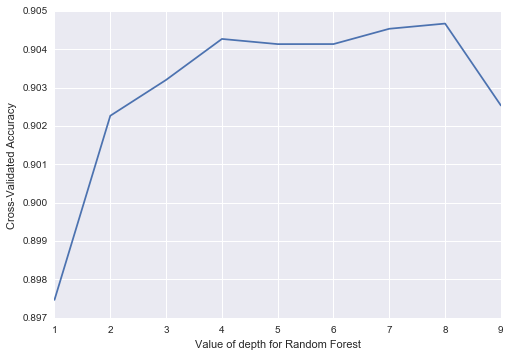

In [16]:

r_range = range(1,10)
r_scores = []
for r in r_range:

	
	
	clf =RF(max_depth=r)
	clf.fit( X_train, y_train)
	scores = cross_val_score(clf, X_train, y_train, cv=7, scoring='accuracy')
	r_scores.append(scores.mean())

print (r_scores) 

plt.plot(r_range, r_scores)
plt.xlabel('Value of depth for Random Forest')
plt.ylabel('Cross-Validated Accuracy')

In [17]:
# confusion matrix 

confusion_matrix(clf.predict(X_test), y_test, labels=[1,0])

array([[  51,   30],
       [ 180, 2239]])

In [18]:
# Normalized confusion matrix 

cm = confusion_matrix(y_test, clf.predict(X_test),labels=[1,0])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('\n Normalized confusion matrix \n')
print(cm_normalized)
plt.figure()


 Normalized confusion matrix 

[[ 0.22077922  0.77922078]
 [ 0.01322168  0.98677832]]


ROC AUC: 0.81


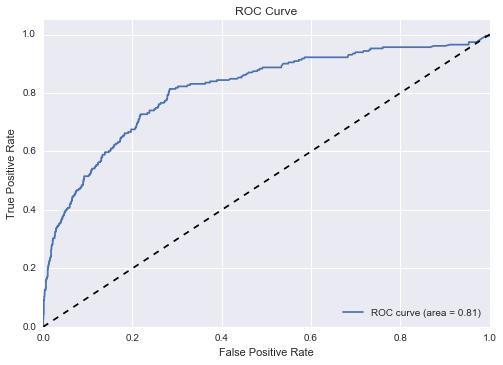

In [19]:
# ROC curve
# shuffle and split training and test sets
# Determine the false positive and true positive rates


fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Random Forest : TEST DATA PREDICTION

In [20]:
# DATA CLEANING 
cs_test=cs_test.drop('SeriousDlqin2yrs', 1)
cs_test['MonthlyIncome'].fillna(cs_test['MonthlyIncome'].mean(),inplace=True)
cs_test['NumberOfDependents'].fillna(cs_test['NumberOfDependents'].mean(),inplace=True)


In [21]:
cs_test.columns=['Id', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

In [22]:
len(cs_test)

101503

In [23]:
X2 = cs_test[['DebtRatio','MonthlyIncome','NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse','RevolvingUtilizationOfUnsecuredLines']]

In [24]:
clf =RF(max_depth=5)
clf.fit(X, Y)
clf.predict_proba(X2)

array([[ 0.83148999,  0.16851001],
       [ 0.94175439,  0.05824561],
       [ 0.9523567 ,  0.0476433 ],
       ..., 
       [ 0.96927338,  0.03072662],
       [ 0.97163459,  0.02836541],
       [ 0.93822829,  0.06177171]])

In [25]:
pd.DataFrame(clf.predict_proba(X2))
outcome=pd.DataFrame(clf.predict_proba(X2))
outcome.head()

,0,1
0,0.831490,0.168510
1,0.941754,0.058246
2,0.952357,0.047643
3,0.819325,0.180675
4,0.804889,0.195111


# Decision Tree 

In [26]:
X = cs_training[['DebtRatio','MonthlyIncome','NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse','RevolvingUtilizationOfUnsecuredLines']]
Y= np.array(cs_training['SeriousDlqin2yrs'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)

clf_ = tree.DecisionTreeClassifier(max_depth=5)
clf_.fit(X_train, y_train)
clf_.score(X_test, y_test)

0.89887499999999998

ROC AUC: 0.72


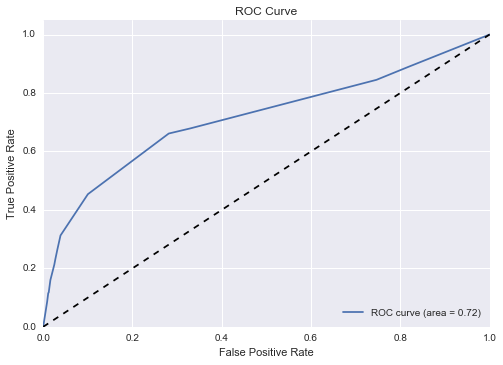

In [27]:
# ROC curve
# shuffle and split training and test sets
# Determine the false positive and true positive rates


fpr, tpr, _ = roc_curve(y_test, clf_.predict_proba(X_test)[:,1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
confusion_matrix(clf_.predict(X_test), y_test, labels=[1,0])

array([[ 170,  179],
       [ 630, 7021]])

In [29]:
cm = confusion_matrix(y_test, clf_.predict(X_test),labels=[1,0])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('\n Normalized confusion matrix \n')
print(cm_normalized)


 Normalized confusion matrix 

[[ 0.2125      0.7875    ]
 [ 0.02486111  0.97513889]]


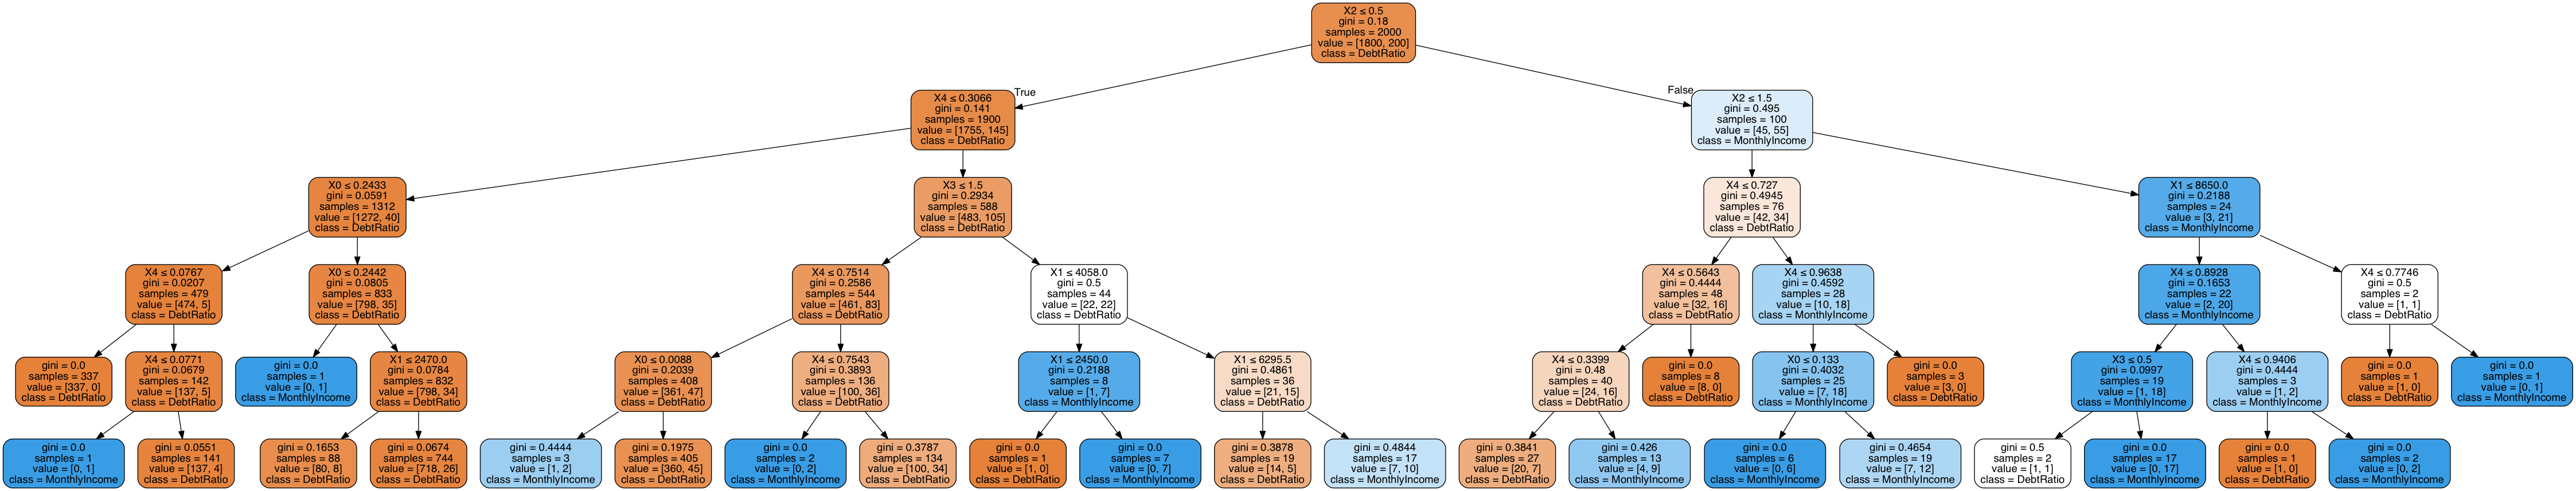

In [30]:
# visualization 
# http://scikit-learn.org/stable/modules/tree.html#classification
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz
# show options of random forest

from sklearn import tree
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image  

class_names = ['DebtRatio', 'MonthlyIncome', 'NumberOfTimes90DaysLate',
       'NumberOfTime30-59DaysPastDueNotWorse',
       'RevolvingUtilizationOfUnsecuredLines']

str_buffer = StringIO()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree.export_graphviz(clf_, out_file=str_buffer ,filled=True, rounded=True,  special_characters=True,class_names=class_names)  
graph = pydotplus.graph_from_dot_data(str_buffer.getvalue())
Image(graph.create_png())

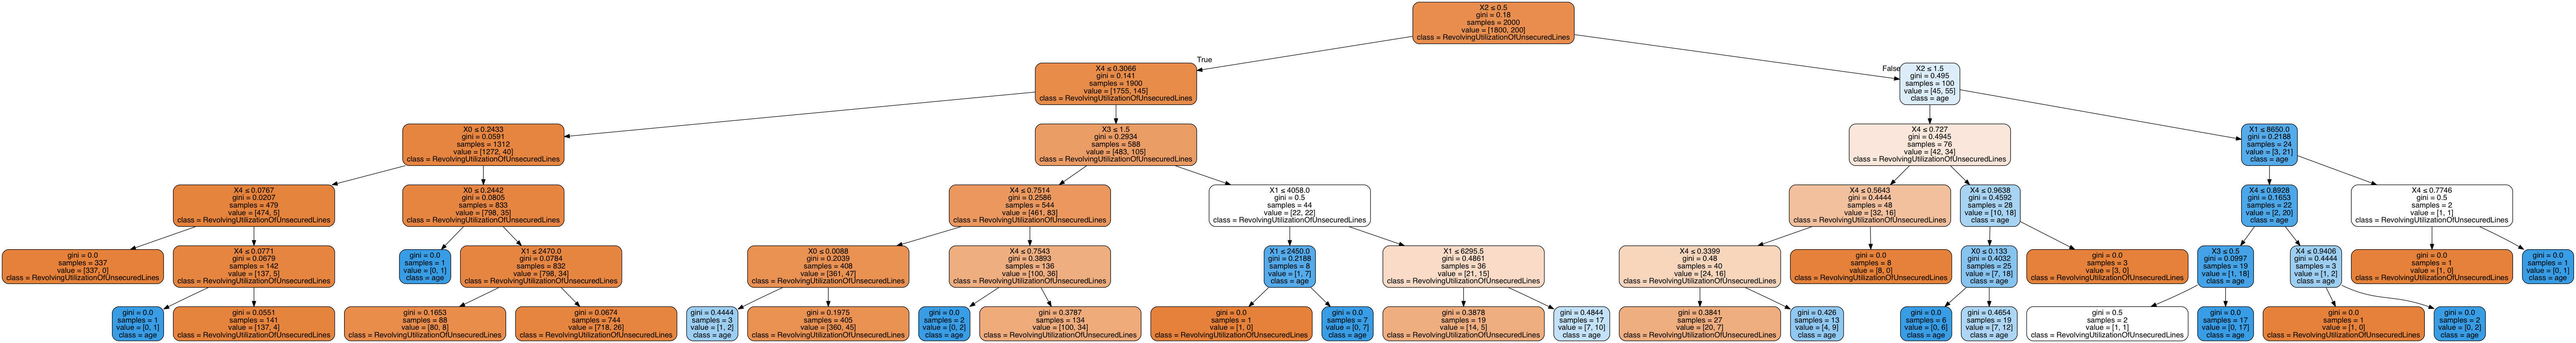

In [31]:
# visualization 
# http://scikit-learn.org/stable/modules/tree.html#classification
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz
# show options of random forest

from sklearn import tree
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image  

class_names = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'DebtRatio_']

str_buffer = StringIO()
clf = tree.DecisionTreeClassifier()
X = cs_training[class_names]
Y = np.array(cs_training['SeriousDlqin2yrs'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)

clf = clf.fit(X_train, y_train)
tree.export_graphviz(clf_, out_file=str_buffer ,filled=True, rounded=True,  special_characters=True,class_names=class_names)  
graph = pydotplus.graph_from_dot_data(str_buffer.getvalue())
Image(graph.create_png())

# Decision Tree : TEST DATA PREDICTION

In [32]:

X = cs_training[['DebtRatio','MonthlyIncome','NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse','RevolvingUtilizationOfUnsecuredLines']]
Y= np.array(cs_training['SeriousDlqin2yrs'])

clf =RF(max_depth=5)

X_train, X_test, y_train, y_test = train_test_split(X, Y)
clf.fit(X_train, y_train)


X2 = cs_test[['DebtRatio','MonthlyIncome','NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse','RevolvingUtilizationOfUnsecuredLines']]
clf.predict_proba(X2)

array([[ 0.83887831,  0.16112169],
       [ 0.9410087 ,  0.0589913 ],
       [ 0.95877957,  0.04122043],
       ..., 
       [ 0.97478046,  0.02521954],
       [ 0.95670984,  0.04329016],
       [ 0.93754169,  0.06245831]])